In [1]:
# Usual imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (18, 10)

# OpenCV
import cv2

# Keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

# Cleverhans
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

# Other modules
from pathlib import Path
from glob import glob
from tqdm.notebook import tqdm

Similar to what we did in Project 1, we will now define some constant for the path to annotations and images

In [2]:
DATA_FOLDER = Path('../data')
IMG_FOLDER = Path(DATA_FOLDER / 'tsrd-train')
ANNOTATIONS = Path(DATA_FOLDER / 'TsignRecgTrain4170Annotation.txt')
COL_NAMES = ['filename','width','height','x1','y1','x2','y2','label']
MODEL_FOLDER = Path('../')
MODEL = Path(MODEL_FOLDER / 'robust_chinese_traffic_sign_classifier.h5')

In [3]:
df = pd.read_csv(ANNOTATIONS, names=COL_NAMES, sep=';', header=None, index_col=False)
old_classifier = load_model(MODEL)

2021-12-09 12:21:50.010299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 12:21:50.018932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 12:21:50.019216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 12:21:50.019782: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
images = glob(str(IMG_FOLDER) + '/*.png')
IMG_SIZE = (134,128)

dataset = []
labels = []

for idx in range(len(images)):
    full_img_path = images[idx]
    filename = Path(full_img_path).name
    img_bgr = cv2.imread(full_img_path)
    image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    image = img_to_array(image)
    dataset.append(image)
    # get label specific to this image
    row = df[df['filename'] == filename]
    label = row['label'].values[0]
    if row.empty:
        print(filename)
    else:
        labels.append(label)

dataset = np.array(dataset) / 255.0
labels = to_categorical(labels)

(train_X, valid_X, train_Y, valid_Y) = train_test_split(dataset, labels,
                                                        test_size=0.2, stratify=labels)

In [5]:
classifier = tf.keras.Model(old_classifier.input, old_classifier.layers[-1].output)

Let's check the accuracy of the model on the validation set we just created

In [6]:
pred_base = classifier.predict(valid_X)
acc_base = np.sum(np.argmax(pred_base, axis=1) == np.argmax(valid_Y, axis=1)) / len(valid_Y)
print(f"Accuracy on validation dataset: {acc_base * 100:.2f}%")

2021-12-09 12:22:02.171452: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-09 12:22:02.521990: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2021-12-09 12:22:02.765035: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Accuracy on validation dataset: 100.00%


Now, similar to what we did in Project 3, we will create adversarial examples using the PGD method.

In [7]:
EPSILON = 0.03 # 0.01 in the hints
NUM_SAMPLES = 50 # 150 in the hints
TARGET_CLASS = 15 # from the hints

idx = np.random.randint(0, valid_X.shape[0], NUM_SAMPLES)
valid_Y_pgd = (np.ones((NUM_SAMPLES,)) * TARGET_CLASS).astype(int)
valid_X_pgd = projected_gradient_descent(classifier, valid_X[idx, :],
                                         eps=EPSILON, norm=np.inf, nb_iter=600, #400 in hints 
                                         eps_iter=EPSILON/10.0, targeted=True,
                                         y=valid_Y_pgd)

Let's check if the pgd method was successful in changing the class of the image to the target class.

In [8]:
pred_pgd = classifier.predict(valid_X_pgd)
success_ratio = np.sum(np.argmax(pred_pgd, axis=1) == TARGET_CLASS) / len(valid_Y_pgd)
print(f"Attack success ratio on {NUM_SAMPLES} adversarial test samples: {success_ratio * 100:.2f}%")

Attack success ratio on 50 adversarial test samples: 8.00%


Now, let's make our classifier robust to the PGD attack. We will do so by training our current classifier with the images from the dataset AND the adversarial images we will create in each training step.

In [9]:
# Using the same values as in the hints
NUM_OF_RETRAIN_ITER = 5
NUM_SAMPLES = 50

es = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=1,
                   restore_best_weights=True, mode='min')

for i in tqdm(range(NUM_OF_RETRAIN_ITER)):
    #classifier = tf.keras.Model(old_classifier.input, old_classifier.layers[-1].output)
    idx = np.random.randint(0, valid_X.shape[0], NUM_SAMPLES)
    Y_pgd = valid_Y[idx, :]
    X_pgd = projected_gradient_descent(classifier, valid_X[idx, :],
                                       eps=EPSILON, norm=np.inf, nb_iter=100,  
                                       eps_iter=EPSILON/10.0, targeted=True,
                                       y=valid_Y_pgd)
    
    
    train_X_tmp = np.concatenate((train_X, X_pgd), axis=0)
    train_Y_tmp = np.concatenate((train_Y, Y_pgd), axis=0)
    
    old_classifier.fit(train_X_tmp, train_Y_tmp, epochs=100, verbose=0, callbacks=[es],
                   validation_data=(X_pgd, Y_pgd), batch_size=8)
    
old_classifier.save('../robust_chinese_traffic_sign_classifier_pgd.h5')

  0%|          | 0/5 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00010: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping


Ok, now that the training is completed, we will check if the model is able to defend against the targeted adversarial attacks.

In [10]:
idx = np.random.randint(0, valid_X.shape[0], NUM_SAMPLES)
valid_Y_pgd = (np.ones((NUM_SAMPLES,)) * TARGET_CLASS).astype(int)
valid_X_pgd = projected_gradient_descent(old_classifier, valid_X[idx, :],
                                         eps=EPSILON, norm=np.inf, nb_iter=600, #400 in hints 
                                         eps_iter=EPSILON/10.0, targeted=True,
                                         y=valid_Y_pgd)

pred_pgd = old_classifier.predict(valid_X_pgd)
success_ratio = np.sum(np.argmax(pred_pgd, axis=1) == TARGET_CLASS) / len(valid_Y_pgd)
print(f"Attack success ratio on {NUM_SAMPLES} adversarial test samples: {success_ratio * 100:.2f}%")

Attack success ratio on 50 adversarial test samples: 0.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


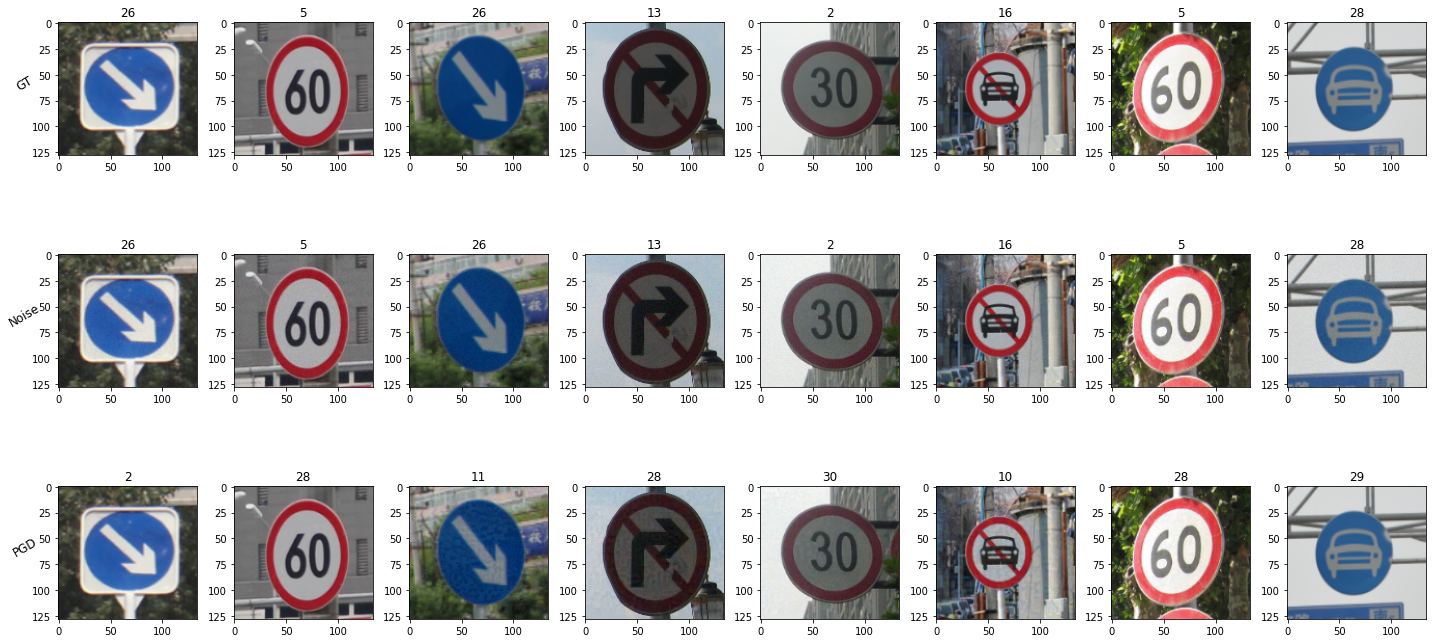

In [12]:
ROWS = 3
COLS = 8
fig, axes = plt.subplots(ROWS, COLS, figsize=(20, 10))

row_labels = ['GT', 'Noise', 'PGD']

idx = np.random.randint(0, valid_X.shape[0], COLS)
valid_X_subset = valid_X[idx, :]
valid_X_pgd = projected_gradient_descent(old_classifier, valid_X_subset, eps=EPSILON, norm=np.inf, nb_iter=600, #400 in hints 
                                         eps_iter=EPSILON/10.0, targeted=True,
                                         y=valid_Y_pgd[:COLS])
valid_X_noise = valid_X_subset + np.random.uniform(low=-EPSILON, high=EPSILON,
                                                    size=valid_X_subset.shape)

pred_base = old_classifier.predict(valid_X_subset)
pred_fgsm = old_classifier.predict(valid_X_pgd)
pred_noise = old_classifier.predict(valid_X_noise)

for k in range(COLS):
    axes[0,k].imshow(valid_X_subset[k])
    axes[1,k].imshow(valid_X_noise[k].clip(0.0,1.0)) #.clip(0.0,1.0)
    axes[2,k].imshow(valid_X_pgd[k])
    
    axes[0,k].set_title(str(pred_base[k].argmax()))
    axes[1,k].set_title(str(pred_noise[k].argmax()))
    axes[2,k].set_title(str(pred_pgd[k].argmax()))
    
for ax, row in zip(axes[:,0], row_labels):
    ax.set_ylabel(row, rotation=30, size='large')

fig.tight_layout()
plt.show()